# Air Quality Prediction Using Machine Learning

## 1. Importing Required Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

## 2. Loading the Dataset

In [2]:
# Load dataset
df = pd.read_csv('AQI_Dataset23_24.csv')

## 3. Data Preprocessing

In [3]:
# Drop the non-numeric 'Timestamp' colum
df = df.drop(columns=['Timestamp'])

In [4]:
# Interpolate all numeric columns linearly
df_interpolated = df.interpolate(method='linear', limit_direction='both')

In [5]:
# Handle remaining NaNs at edges (start or end)
df_filled = df_interpolated.ffill().bfill()

In [6]:
# Create AQI of next day column
df_filled['AQI_Day2'] = df_filled['AQI'].shift(-1).fillna(30.0)

In [7]:
# Drop the last row since AQI_Tomorrow will be NaN
df_filled = df_filled.dropna()

## 4. Exploratory Data Analysis (EDA)

In [79]:
df_filled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PM2.5 (µg/m³)  731 non-null    float64
 1   PM10 (µg/m³)   731 non-null    float64
 2   NO2 (µg/m³)    731 non-null    float64
 3   NH3 (µg/m³)    731 non-null    float64
 4   SO2 (µg/m³)    731 non-null    float64
 5   CO (mg/m³)     731 non-null    float64
 6   Ozone (µg/m³)  731 non-null    float64
 7   AQI            731 non-null    int64  
 8   AQI_Day2       731 non-null    float64
dtypes: float64(8), int64(1)
memory usage: 51.5 KB


In [9]:
df_filled.describe()

,PM2.5 (µg/m³),PM10 (µg/m³),NO2 (µg/m³),NH3 (µg/m³),SO2 (µg/m³),CO (mg/m³),Ozone (µg/m³),AQI,AQI_Day2
count,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
mean,30.381092,59.663037,12.151884,5.453840,21.076018,0.704098,13.582796,59.990424,59.886457
std,20.506035,29.836956,17.346604,3.801461,7.432259,0.547890,17.070808,26.295031,26.263094
min,3.400000,9.440000,0.060000,1.590000,8.033750,0.000000,0.650000,18.000000,18.000000
25%,17.190000,35.025000,1.260000,2.615000,15.487708,0.345156,3.982552,38.000000,38.000000
50%,26.700000,55.940000,3.680000,3.702396,21.270000,0.532917,6.374062,55.000000,55.000000
75%,38.230015,79.325625,18.537865,10.349749,23.730000,0.870000,14.000000,78.000000,78.000000
max,299.084375,193.689891,286.670000,14.616250,57.980000,3.055909,126.020000,192.000000,192.000000


### Correlation Matrix Heatmap

In [10]:
#Visualizes linear relationships between features

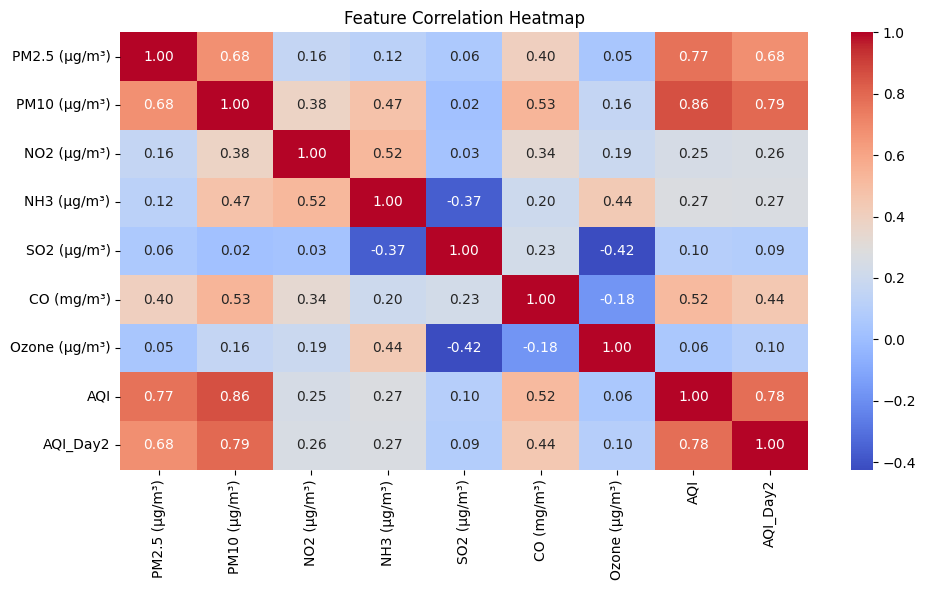

In [11]:
# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df_filled.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()

### Boxplots for Outlier Detection and Distribution Spread

In [12]:
# Visualize distribution and outliers

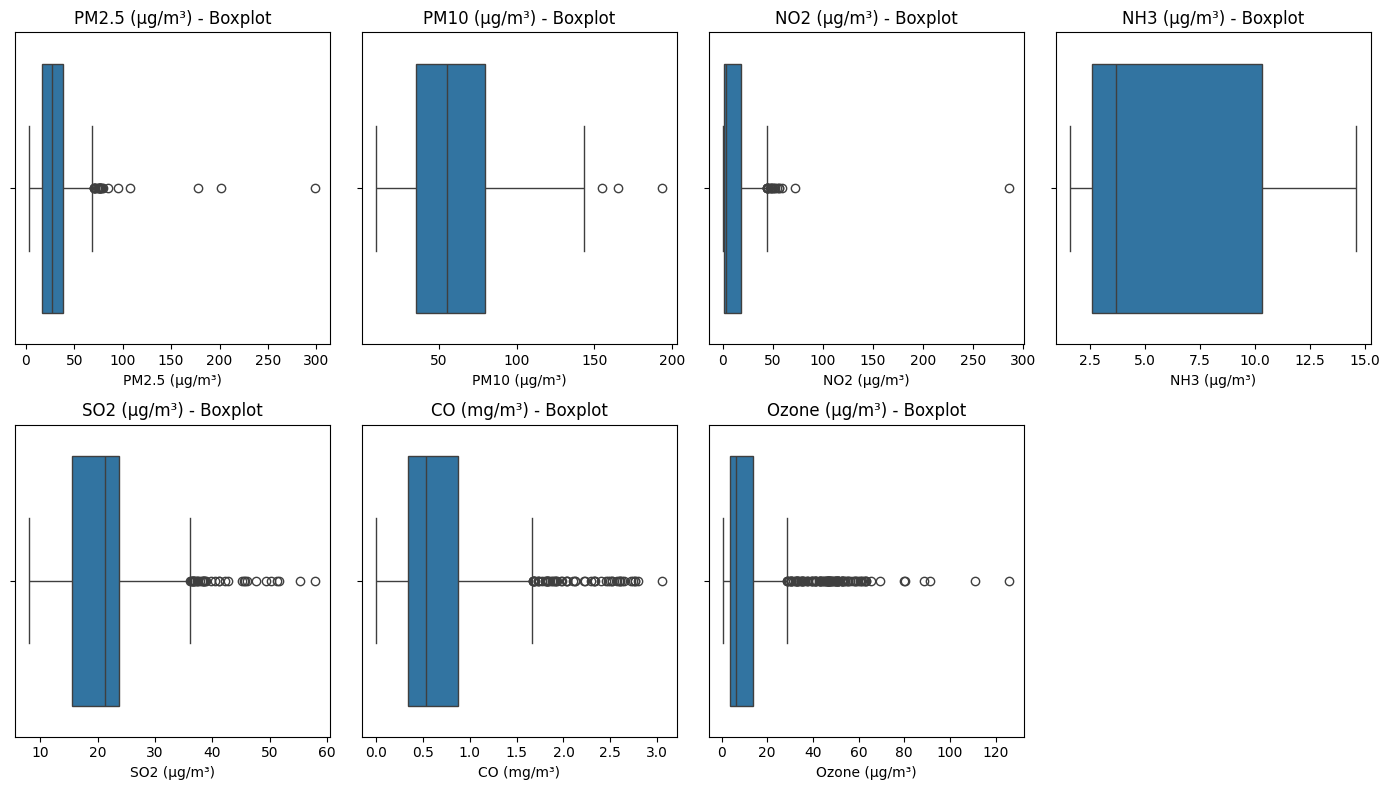

In [13]:
plt.figure(figsize=(14, 8))
for i, col in enumerate(df_filled.columns[:-2], 1):  # exclude AQI from last to keep plots clean
    plt.subplot(2, 4, i)
    sns.boxplot(x=df[col])
    plt.title(f"{col} - Boxplot")
    plt.tight_layout()

plt.show()

### Skewness and Kurtosis Analysis with Histograms

In [14]:
#Measures the symmetry and tailedness of feature distributions

In [15]:
# Calculate Skewness
skewness = df_filled.skew().sort_values(ascending=False)

# Calculate Kurtosis
kurtosis = df_filled.kurt().sort_values(ascending=False)

# Combine both into one DataFrame for easy viewing
distribution_shape = pd.DataFrame({
    'Skewness': skewness,
    'Kurtosis': kurtosis
})

# Display result
print(distribution_shape)

               Skewness   Kurtosis
AQI            0.952481   1.261545
AQI_Day2       0.958438   1.286877
CO (mg/m³)     1.718709   2.922985
NH3 (µg/m³)    0.900078  -0.867404
NO2 (µg/m³)    6.560076  89.681122
Ozone (µg/m³)  2.404759   6.914809
PM10 (µg/m³)   0.722014   0.258137
PM2.5 (µg/m³)  4.816796  49.569836
SO2 (µg/m³)    1.101981   2.759134


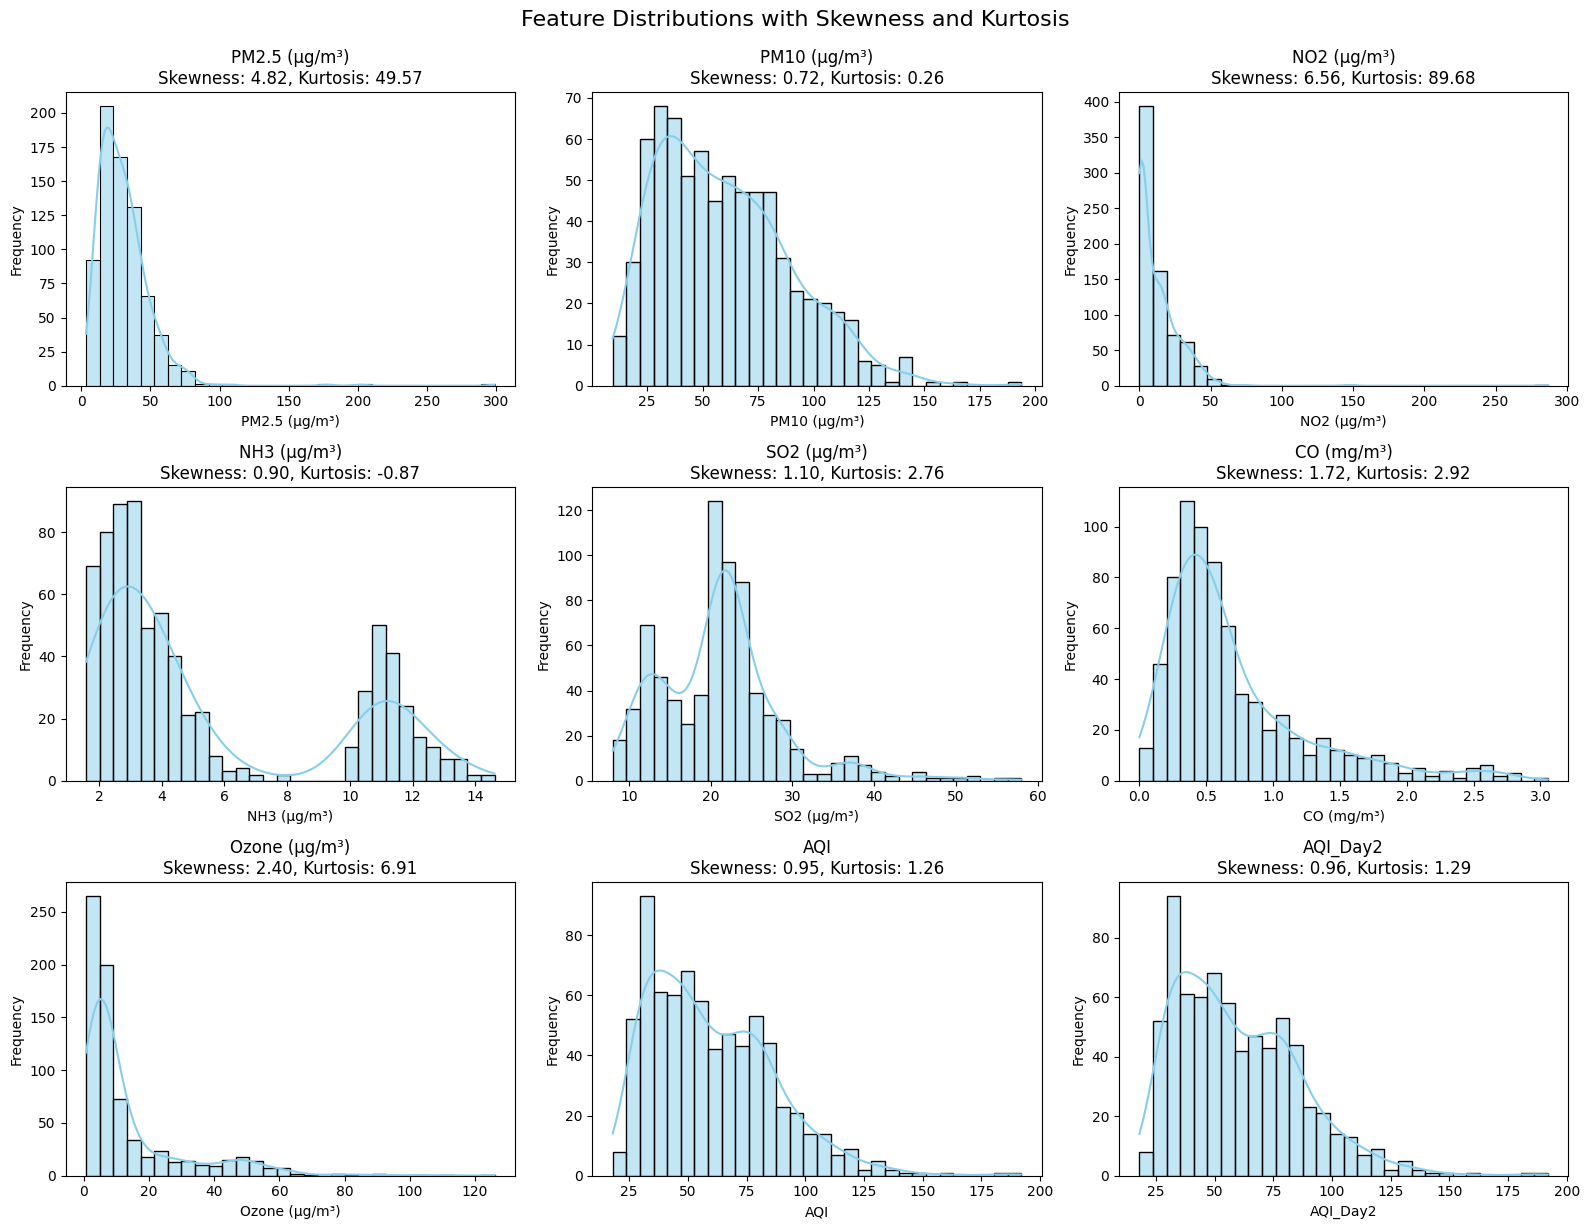

In [16]:
# Plot histograms with skewness and kurtosis
plt.figure(figsize=(16, 12))
for i, col in enumerate(df_filled.columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df_filled[col], kde=True, color='skyblue', bins=30)
    skew = df_filled[col].skew()
    kurt = df_filled[col].kurt()
    plt.title(f"{col}\nSkewness: {skew:.2f}, Kurtosis: {kurt:.2f}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()

plt.suptitle("Feature Distributions with Skewness and Kurtosis", fontsize=16, y=1.02)
plt.show()

### Feature Distribution Analysis using Histograms

In [17]:
#Shows frequency distribution for each pollutant

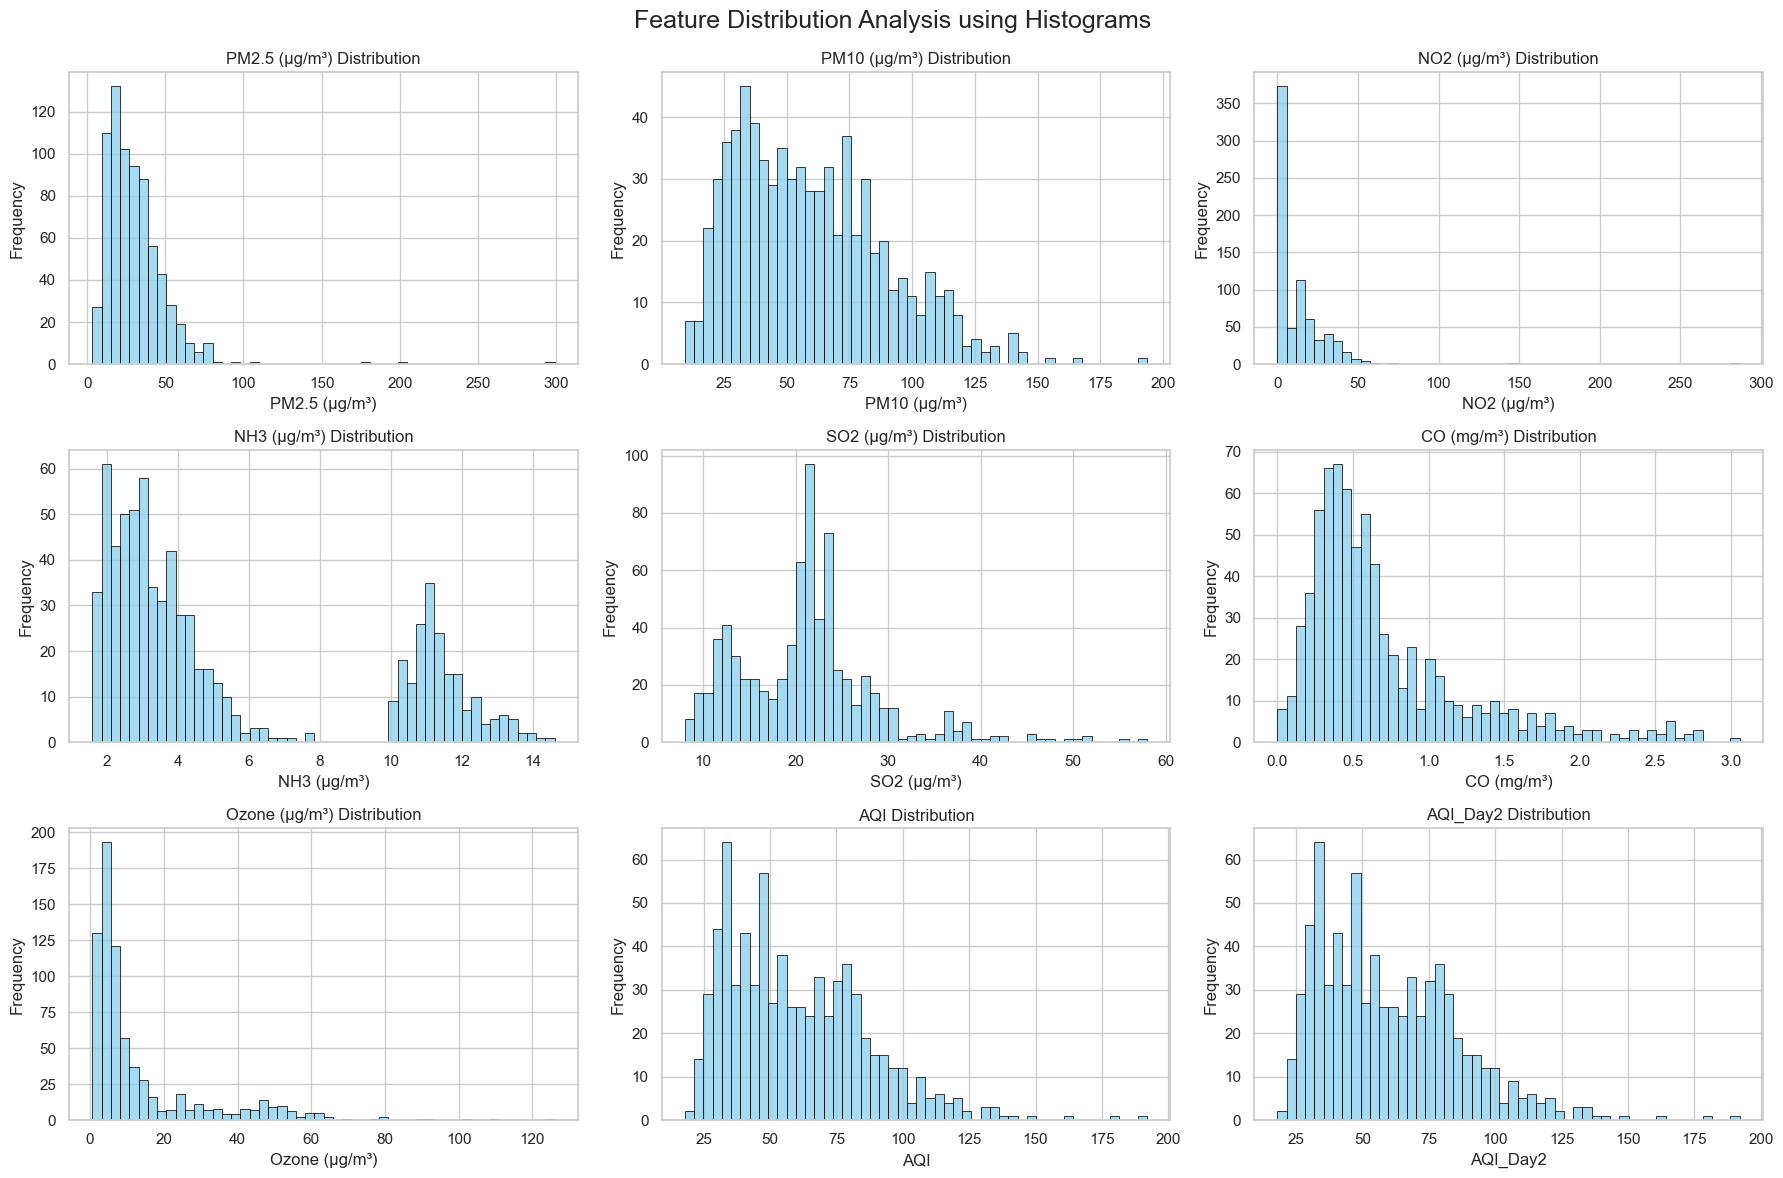

In [18]:
# Set Seaborn style for better visuals
sns.set(style="whitegrid")

# Create subplots
num_cols = len(df_filled.columns)
cols_per_row = 3
rows = (num_cols + cols_per_row - 1) // cols_per_row

plt.figure(figsize=(cols_per_row * 6, rows * 4))

for i, col in enumerate(df_filled.columns, 1):
    plt.subplot(rows, cols_per_row, i)
    sns.histplot(df_filled[col], bins=50, color='skyblue', edgecolor='black')
    plt.title(f"{col} Distribution", fontsize=12)
    plt.xlabel(col)
    plt.ylabel("Frequency")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle("Feature Distribution Analysis using Histograms", fontsize=18)
plt.show()


### AQI Category-Wise Bar Chart

In [19]:
#Displays the number of days under each AQI category

Text(0, 0.5, 'Number of Days')

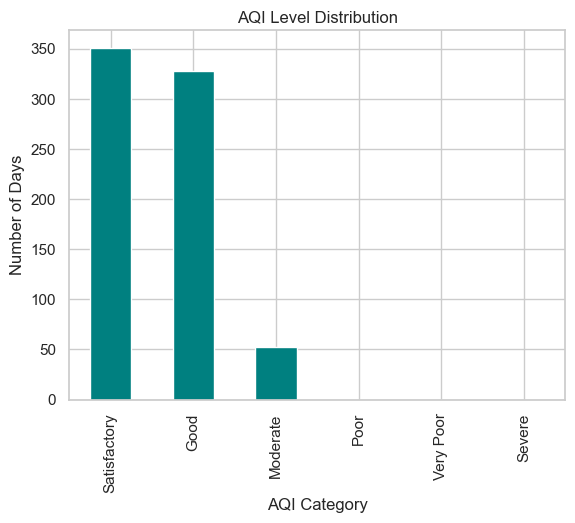

In [20]:
df['AQI_Level'] = pd.cut(df_filled['AQI'],
                         bins=[0, 50, 100, 200, 300, 400, 500],
                         labels=['Good', 'Satisfactory', 'Moderate', 'Poor', 'Very Poor', 'Severe'])

df['AQI_Level'].value_counts().plot(kind='bar', color='teal')
plt.title('AQI Level Distribution')
plt.xlabel('AQI Category')
plt.ylabel('Number of Days')

### Scatter Plots between Pollutants and AQI

In [21]:
#Helps understand direct relationships between AQI and each pollutant

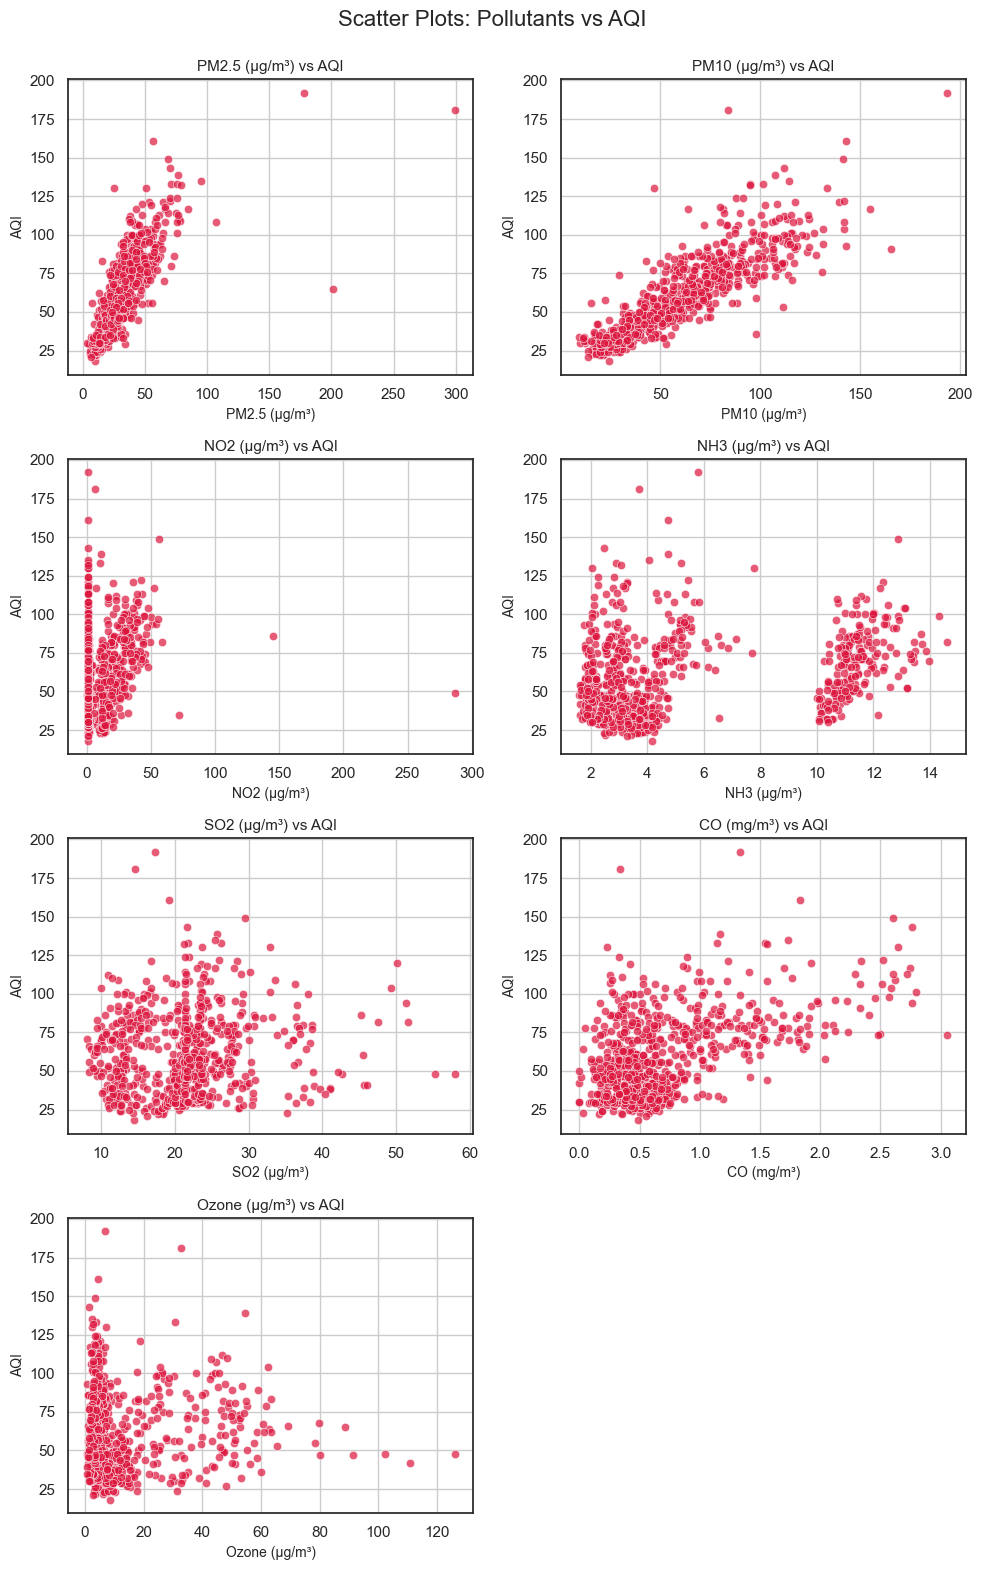

In [81]:
# List of pollutants
pollutants = ['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'NO2 (µg/m³)', 
              'NH3 (µg/m³)', 'SO2 (µg/m³)', 'CO (mg/m³)', 'Ozone (µg/m³)']

# Set number of plots per row
plots_per_row = 2
total_plots = len(pollutants)
rows = (total_plots + plots_per_row - 1) // plots_per_row

plt.figure(figsize=(plots_per_row * 5, rows * 4))

for i, col in enumerate(pollutants, 1):
    plt.subplot(rows, plots_per_row, i)
    sns.scatterplot(x=df_filled[col], y=df_filled['AQI'], color='crimson', alpha=0.7)
    plt.title(f'{col} vs AQI', fontsize=11)
    plt.xlabel(col, fontsize=10)
    plt.ylabel('AQI', fontsize=10)
    plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.suptitle("Scatter Plots: Pollutants vs AQI", fontsize=16)
plt.show()


## D5. Data Visualization

### Time Series Line Plot of AQI over Two Years

In [23]:
#Visualizes AQI trends across the entire duration

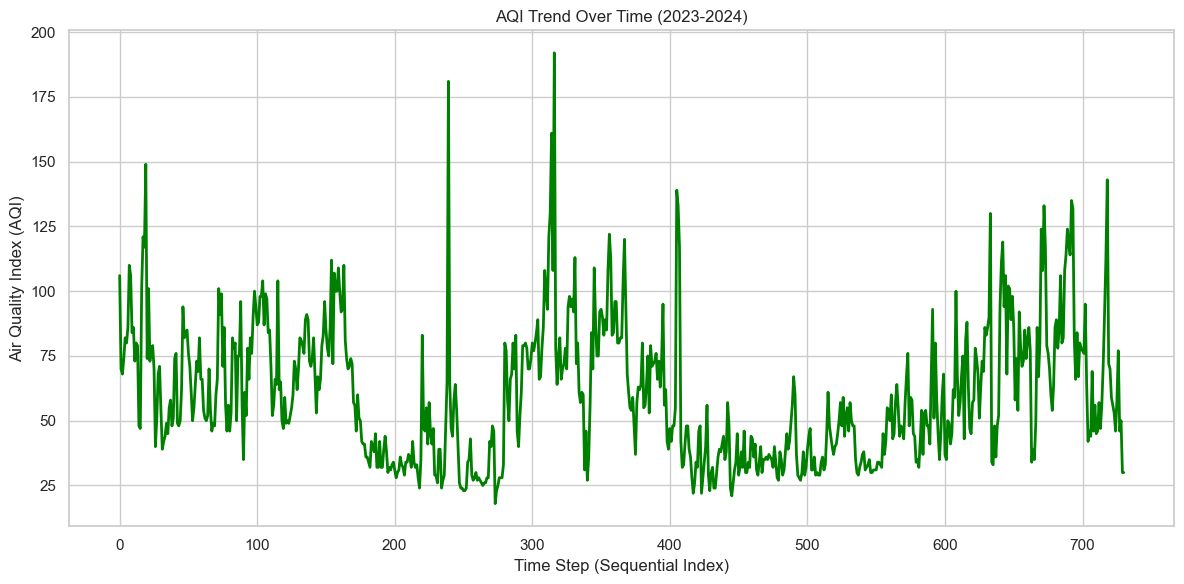

In [24]:
#Line plots to observe trends in AQI over Time
plt.figure(figsize=(12, 6))
plt.plot(df_filled.index, df_filled['AQI'], color='green', linewidth=2)
plt.title('AQI Trend Over Time (2023-2024)')
plt.xlabel('Time Step (Sequential Index)')
plt.ylabel('Air Quality Index (AQI)')
plt.grid(True)
plt.tight_layout()
plt.show()

### Individual Time Series Line Plots for Each Pollutant

In [25]:
#Displays how each pollutant varies over time

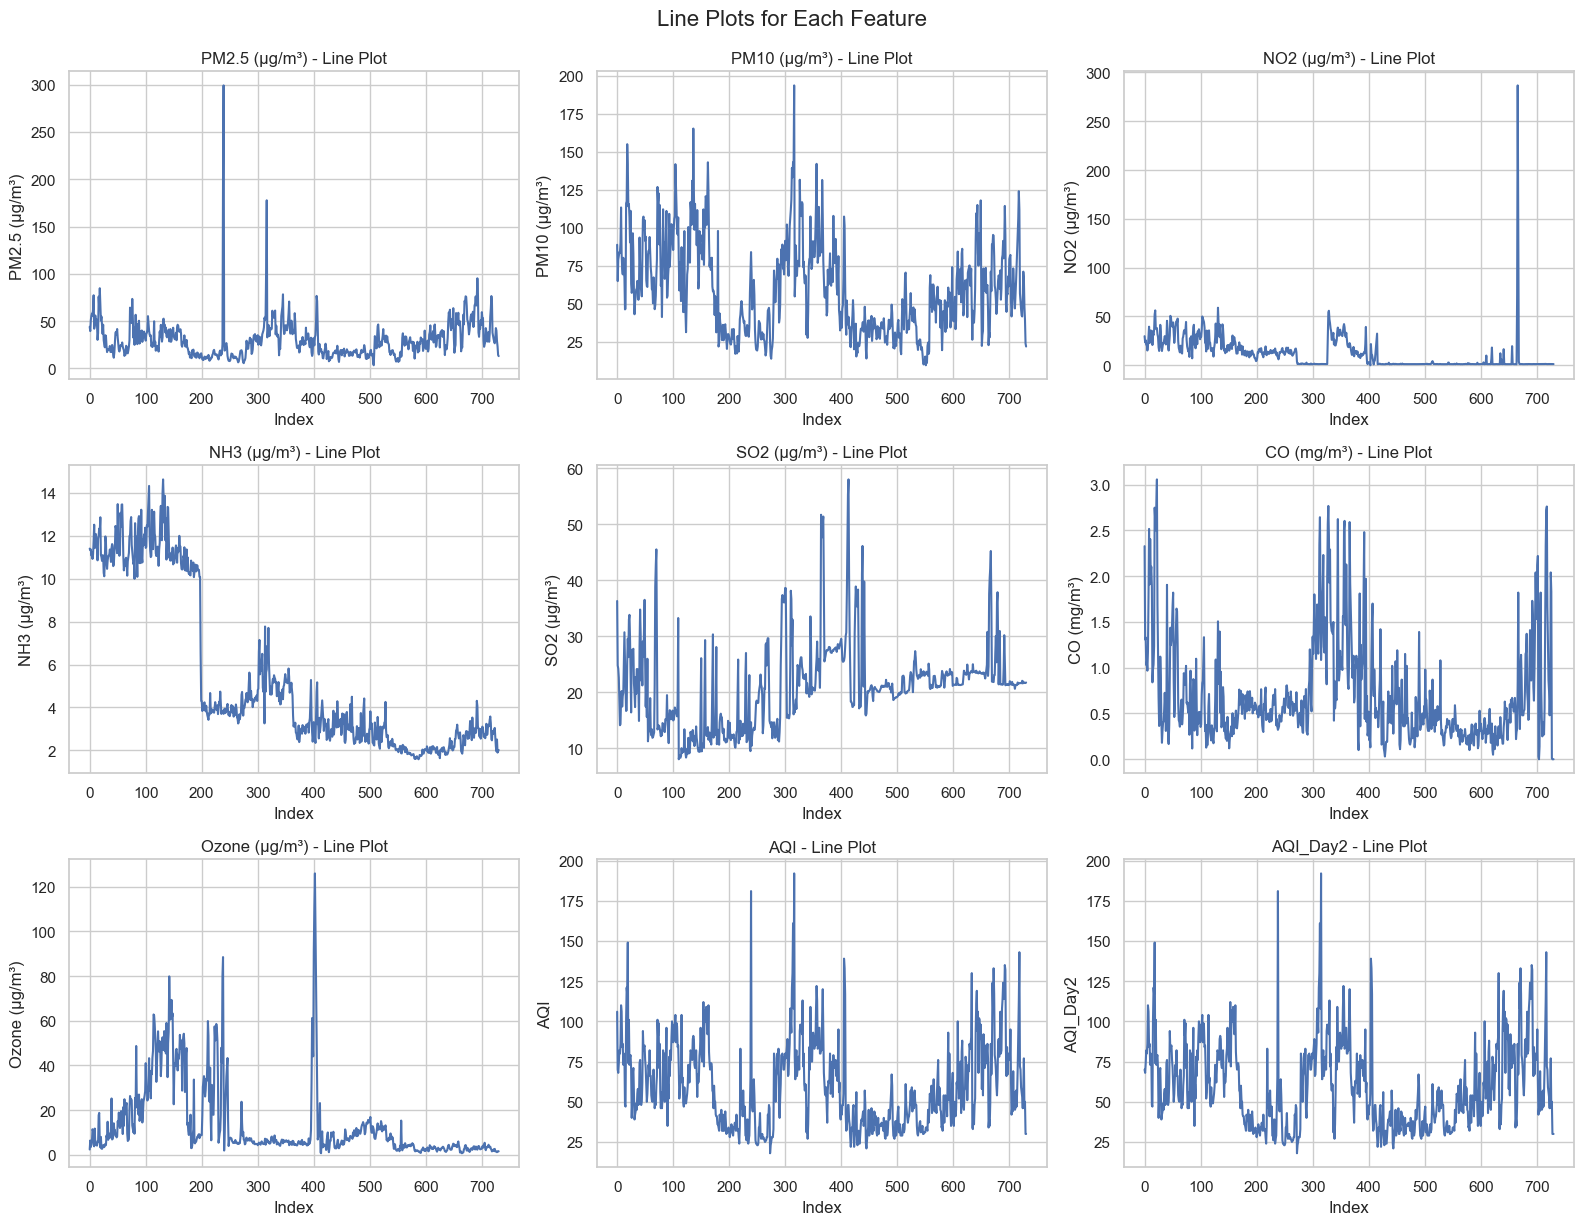

In [26]:
# Plotting line graphs separately for each feature
plt.figure(figsize=(16, 12))
for i, col in enumerate(df_filled.columns, 1):
    plt.subplot(3, 3, i)
    plt.plot(df_filled[col])
    plt.title(f"{col} - Line Plot")
    plt.xlabel("Index")
    plt.ylabel(col)
    plt.tight_layout()

plt.suptitle("Line Plots for Each Feature", fontsize=16, y=1.02)
plt.show()

### Rolling Average Trend Plots (7-Day Window) for Each Pollutant

In [27]:
#Smooths fluctuations to show long-term patterns

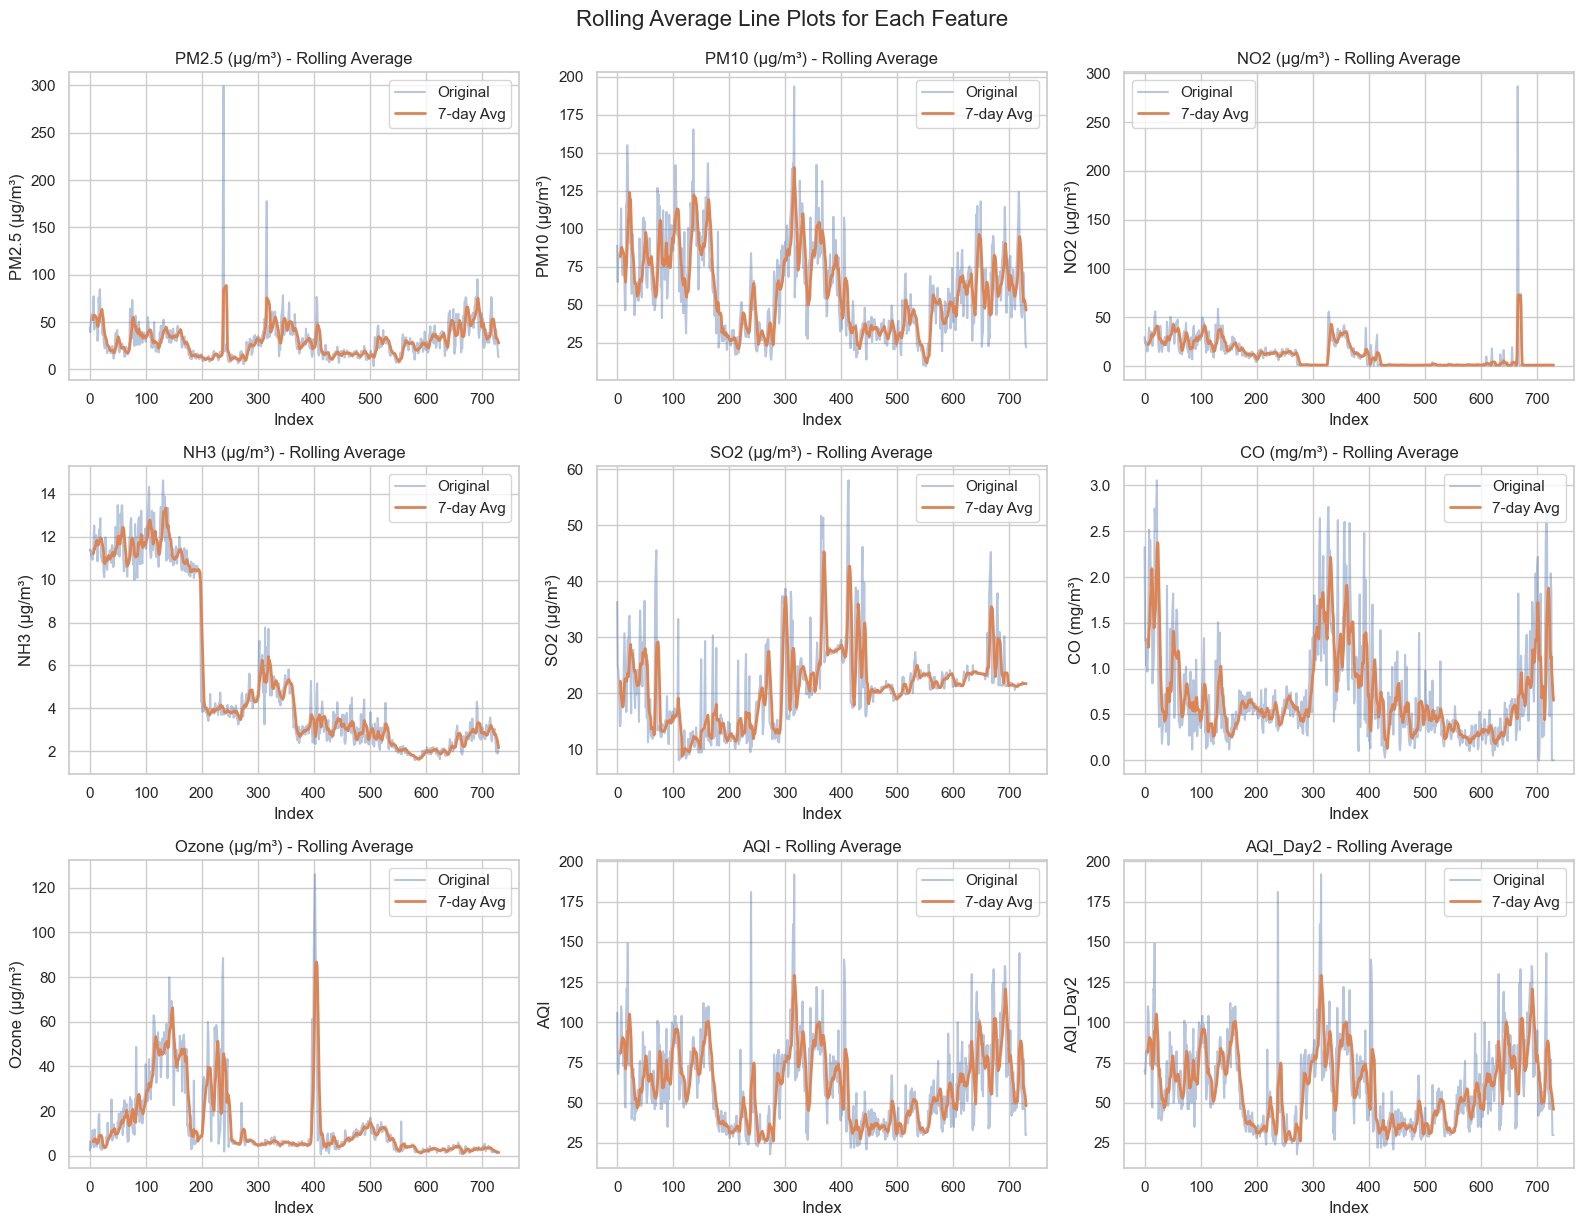

In [28]:
window_size = 7

# Create subplots for each feature with rolling average
plt.figure(figsize=(16, 12))
for i, col in enumerate(df_filled.columns, 1):
    plt.subplot(3, 3, i)
    plt.plot(df_filled[col], label="Original", alpha=0.4)
    plt.plot(df_filled[col].rolling(window=window_size).mean(), label=f"{window_size}-day Avg", linewidth=2)
    plt.title(f"{col} - Rolling Average")
    plt.xlabel("Index")
    plt.ylabel(col)
    plt.legend()
    plt.tight_layout()

plt.suptitle("Rolling Average Line Plots for Each Feature", fontsize=16, y=1.02)
plt.show()

### Pollutant Contribution to AQI – Stacked Bar Chart

In [29]:
#Compares the relative contribution of each pollutant to overall AQI

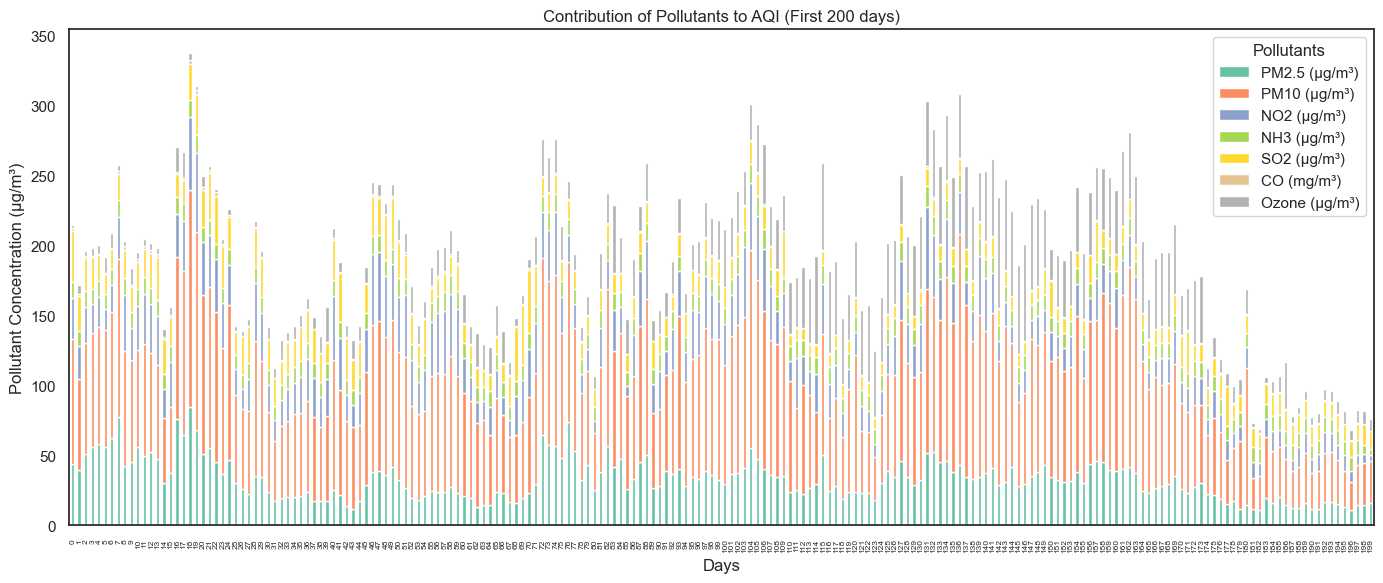

In [30]:
sns.set(style="white")

# Assuming df_filled is your preprocessed DataFrame and contains the relevant columns
pollutants = ['PM2.5 (µg/m³)', 'PM10 (µg/m³)', 'NO2 (µg/m³)', 'NH3 (µg/m³)', 'SO2 (µg/m³)', 'CO (mg/m³)', 'Ozone (µg/m³)']
# Select a sample for better visualization (e.g., first 200 days)
df_sample = df_filled[pollutants + ['AQI']].head(200)

# Create stacked bar chart
ax = df_sample[pollutants].plot(kind='bar', stacked=True, figsize=(14, 6), colormap='Set2')
plt.title("Contribution of Pollutants to AQI (First 200 days)")
plt.xlabel("Days")
plt.ylabel("Pollutant Concentration (µg/m³)")
plt.xticks(fontsize=6, rotation=90)
plt.legend(title="Pollutants")
plt.tight_layout()
plt.show()


## 6. Feature Scaling

In [31]:
# Feature and target separation
X = df_filled.drop(['AQI', 'AQI_Day2'], axis=1)

# Target 1: Current Day AQI
y_today = df_filled['AQI']

# Target 2: Next Day AQI
y_day2 = df_filled['AQI_Day2']

In [32]:
# Scale the data (standardization)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 7. Train-Test Split

In [33]:
# Train-test split
X_train, X_test, y1_train, y1_test = train_test_split(X_scaled, y_today, test_size=0.22, random_state=0)
Xt1, Xt2, y2_train, y2_test = train_test_split(X_scaled, y_day2, test_size=0.29, random_state=42)

## 8. Model Training and Evaluation

### 8.1 Linear Regression

In [34]:
# first object for same day AQi
lr1 = LinearRegression() 
# Fit the model for next day AQI
lr1.fit(X_train, y1_train)

LinearRegression()

In [35]:
# Predictions
pred_today_1 = lr1.predict(X_test)

In [36]:
r2_today_1 = r2_score(y1_test, pred_today_1)

In [37]:
r2_today_1

0.8607165844971333

In [38]:
# Train model for AQI tomorrow
lr2 = LinearRegression()
lr2.fit(Xt1, y2_train)

LinearRegression()

In [39]:
# Predictions
pred_day2_1 = lr2.predict(Xt2)

In [40]:
r2_day2_1 = r2_score(y2_test, pred_day2_1)

In [41]:
r2_day2_1

0.7100285745156425

### 8.2 Decision Tree Regressor

In [42]:
model_today2 = DecisionTreeRegressor(    # first object for next day AQi
    max_depth=100,
    min_samples_split=100,
    min_samples_leaf=5,
    random_state=42
)

In [43]:
model_today2.fit(X_train, y1_train)

DecisionTreeRegressor(max_depth=100, min_samples_leaf=5, min_samples_split=100,
                      random_state=42)

In [44]:
pred_today_2 = model_today2.predict(X_test)

In [45]:
r2_today_2 = r2_score(y1_test, pred_today_2)

In [46]:
r2_today_2

0.7475234593927944

In [47]:
model_day2_2 = DecisionTreeRegressor(    # first object for next day AQi
    max_depth=100,
    min_samples_split=100,
    min_samples_leaf=5,
    random_state=42
)

In [48]:
model_day2_2.fit(Xt1, y2_train)

DecisionTreeRegressor(max_depth=100, min_samples_leaf=5, min_samples_split=100,
                      random_state=42)

In [49]:
pred_day2_2 = model_today2.predict(Xt2)

In [50]:
r2_day2_2 = r2_score(y2_test, pred_day2_2)

In [51]:
r2_day2_2

0.6732476017343043

### 8.3 Random Forest Regressor

In [52]:
param_grid = {
    'n_estimators': [100, 200, 300, 500, 700, 1000],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

In [53]:
model_today3 = RandomForestRegressor(random_state=42)  # first object for next day AQi

In [54]:
search1 = RandomizedSearchCV(
    estimator= model_today3,
    param_distributions= param_grid,
    n_iter= 10,
    cv= 5,
    scoring= 'r2',
    random_state= 42,
    n_jobs= -1,
     verbose=1
)
    

In [55]:
search1.fit(X_train, y1_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500,
                                                         700, 1000]},
                   random_state=42, scoring='r2', verbose=1)

In [56]:
pred_today_3 = search1.predict(X_test)

In [57]:
r2_today_3=r2_score(y1_test, pred_today_3)

In [58]:
r2_today_3

0.8334342744195301

In [59]:
model_day2_3 = RandomForestRegressor(random_state=0)  # first object for next day AQi

In [60]:
search2 = RandomizedSearchCV(
    estimator= model_day2_3,
    param_distributions= param_grid,
    n_iter= 10,
    cv= 5,
    scoring= 'r2',
    random_state= 42,
    n_jobs= -1,
     verbose=1
)

In [61]:
search2.fit(Xt1, y2_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=0),
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, None],
                                        'max_features': ['sqrt', 'log2', None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 500,
                                                         700, 1000]},
                   random_state=42, scoring='r2', verbose=1)

In [62]:
pred_day2_3 = search2.predict(Xt2)

In [63]:
r2_day2_3=r2_score(y2_test, pred_day2_3)

In [64]:
r2_day2_3

0.7205318184712751

### 8.4 Support Vector Regressor (SVR)

In [65]:
from sklearn.svm import SVR

In [66]:
param_grid2={
    'C': [0.1, 1, 5, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto'],
    'epsilon': [0.01, 0.1, 0.2]
}

In [67]:
model_svr = SVR()     # first object for next day AQi

In [68]:
search3 = RandomizedSearchCV(
    estimator= model_svr,
    param_distributions= param_grid2,
    n_iter= 50,
    cv= 5,
    random_state= 42,
    n_jobs= -1,
    scoring= 'r2',
    verbose= 1
)

In [69]:
search3.fit(X_train, y1_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 5, 10],
                                        'epsilon': [0.01, 0.1, 0.2],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'rbf', 'poly']},
                   random_state=42, scoring='r2', verbose=1)

In [70]:
pred_today_4 = search3.predict(X_test)

In [71]:
r2_today_4 = r2_score(y1_test, pred_today_4)

In [72]:
r2_today_4

0.8666799834781898

In [73]:
search4 = RandomizedSearchCV(
    estimator= model_svr,
    param_distributions= param_grid2,
    n_iter= 50,
    cv= 5,
    random_state= 42,
    n_jobs= -1,
    scoring= 'r2',
    verbose= 1
)

In [74]:
search4.fit(Xt1, y2_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5, estimator=SVR(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 5, 10],
                                        'epsilon': [0.01, 0.1, 0.2],
                                        'gamma': ['scale', 'auto'],
                                        'kernel': ['linear', 'rbf', 'poly']},
                   random_state=42, scoring='r2', verbose=1)

In [75]:
pred_day2_4 = search4.predict(Xt2)

In [76]:
r2_day2_4= r2_score(y2_test, pred_day2_4)

In [77]:
r2_day2_4

0.6906502492184021

## 9. Model Comparison

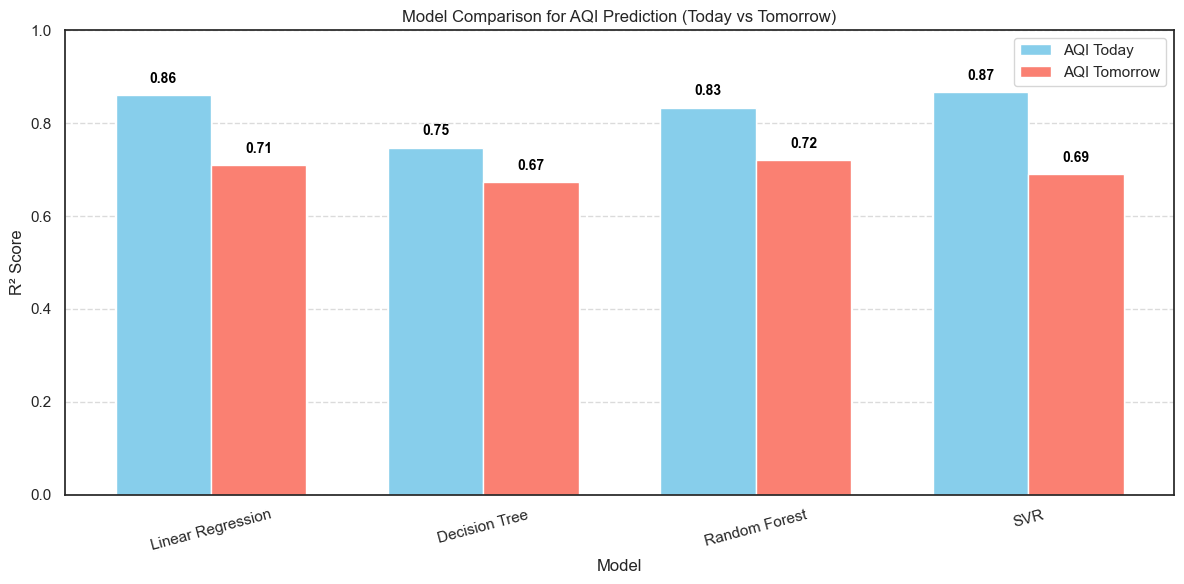

In [78]:
# Model names and scores
model_names = ['Linear Regression', 'Decision Tree', 'Random Forest', 'SVR']
r2_scores_day1 = [r2_today_1, r2_today_2, r2_today_3, r2_today_4]
r2_scores_day2 = [r2_day2_1, r2_day2_2, r2_day2_3, r2_day2_4]

# Bar width and positions
bar_width = 0.35
index = np.arange(len(model_names))

# Plotting
plt.figure(figsize=(12, 6))
plt.bar(index, r2_scores_day1, bar_width, label='AQI Today', color='skyblue')
plt.bar(index + bar_width, r2_scores_day2, bar_width, label='AQI Tomorrow', color='salmon')

# Labels and formatting
plt.xlabel('Model')
plt.ylabel('R² Score')
plt.title('Model Comparison for AQI Prediction (Today vs Tomorrow)')
plt.xticks(index + bar_width / 2, model_names, rotation=15)
plt.ylim(0, 1)  # since R² scores range between 0 and 1
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

for i in range(len(model_names)):
    # Annotate AQI Today (left bar)
    plt.text(i, r2_scores_day1[i] + 0.02, f'{r2_scores_day1[i]:.2f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')

    # Annotate AQI Tomorrow (right bar)
    plt.text(i + bar_width, r2_scores_day2[i] + 0.02, f'{r2_scores_day2[i]:.2f}', 
             ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')
plt.show()
